# NeuralOperator + Physics on PytorchLightening on Turbulent Data

In [79]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from turboflow.dataloaders import DataModule

import scipy.stats as stats

np.random.seed(666)

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## Input data

Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


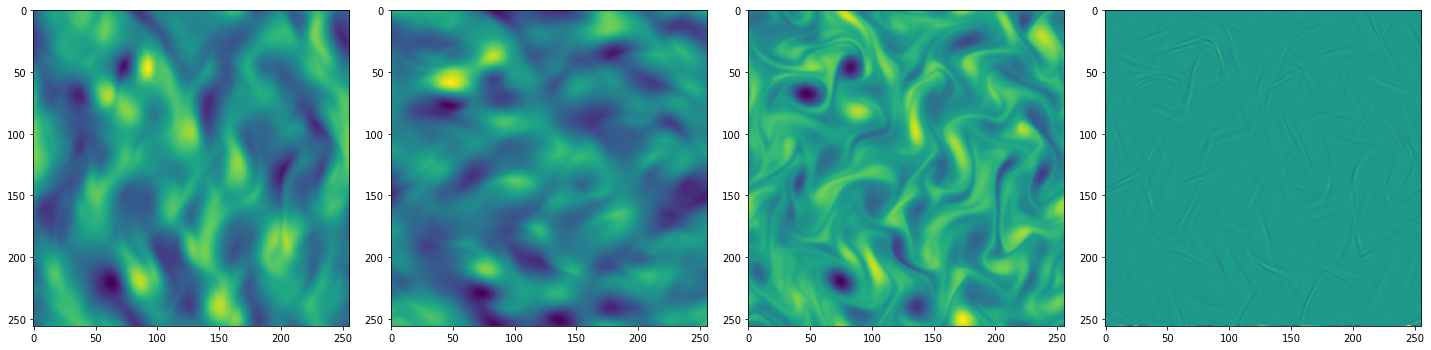

In [5]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2]
V = IMGs[img_index,:,:,3]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

W = phy.compute_vorticity(U,V)
D = phy.compute_divergence(U,V)

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U)
plt.subplot(142)
plt.imshow(V)
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

In [6]:
# normalize output
y = IMGs[img_index,:,:,2:4]
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

assert np.max(np.abs(y)) <= 1.0
assert np.max(np.abs(X)) >= 0
assert np.max(np.abs(X)) <= 1.0

Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


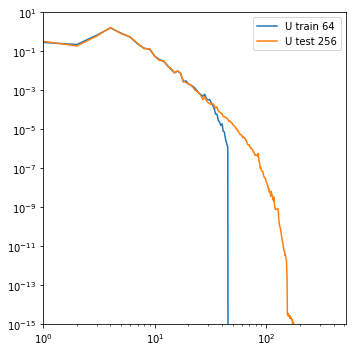

In [101]:
Xtest = X
ytest = y

# downsampled resultion
scale = 1/4
X1ds = dsp.interpolate2D(X, X[:,:,0], scale=scale)[:,:,None]
X2ds = dsp.interpolate2D(X, X[:,:,1], scale=scale)[:,:,None]
y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]

Xtrain = np.concatenate([X1ds, X2ds], axis=-1)
ytrain = np.concatenate([y1ds, y2ds], axis=-1)

# fig, axs = plt.subplots(1,2)
# axs[0].imshow(ytest[:,:,0])
# axs[1].imshow(ytest[:,:,1])
# plt.show()

# fig, axs = plt.subplots(1,2)
# axs[0].imshow(ytrain[:,:,0])
# axs[1].imshow(ytrain[:,:,1])
# plt.show()

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

K41 = np.linspace(0,256,1000)

# b1, b0, _r, _p_val, _stderr = stats.linregress(np.log10(mx), np.log10(my)) 

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

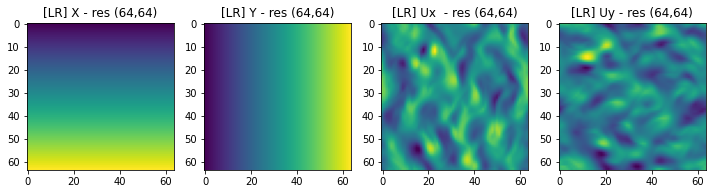

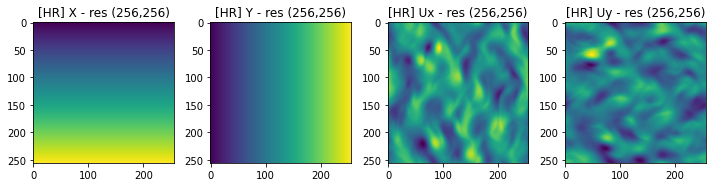

In [102]:
plt.figure(figsize=(10,5))
plt.subplot(141)
plt.title('[LR] X - res (%d,%d)' % Xtrain[:,:,0].shape)
plt.imshow(Xtrain[:,:,0])
plt.subplot(142)
plt.title('[LR] Y - res (%d,%d)' % Xtrain[:,:,1].shape)
plt.imshow(Xtrain[:,:,1])
plt.subplot(143)
plt.title('[LR] Ux  - res (%d,%d)' % ytrain[:,:,0].shape)
plt.imshow(ytrain[:,:,0])
plt.subplot(144)
plt.title('[LR] Uy - res (%d,%d)' % ytrain[:,:,1].shape)
plt.imshow(ytrain[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_train.pdf', dpi=150)
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.title('[HR] X - res (%d,%d)' % Xtest[:,:,0].shape)
plt.imshow(Xtest[:,:,0])
plt.subplot(142)
plt.title('[HR] Y - res (%d,%d)' % Xtest[:,:,1].shape)
plt.imshow(Xtest[:,:,1])
plt.subplot(143)
plt.title('[HR] Ux - res (%d,%d)' % ytest[:,:,0].shape)
plt.imshow(ytest[:,:,0])
plt.subplot(144)
plt.title('[HR] Uy - res (%d,%d)' % ytest[:,:,1].shape)
plt.imshow(ytest[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_test.pdf', dpi=150)
plt.show()

## LEARNING TURBULENCES

In [7]:
class MyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        # assert np.max(np.abs(X)) <= 1

        'Initialization'
        print(X.shape)
        print(y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('Dimension error')
            print('X', X.shape)
            print('y', y.shape)

        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]

            
  def __len__(self):
        'Denotes the total number of samples'
        return 1

    
  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs
        y = self.target

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data):
        
        super().__init__()
        self.batch_size = 1
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 1)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 1)

In [8]:
# test data loader
dm_dict['RFF'].prepare_data()
for batch in dm_dict['RFF'].train_dataloader():
    X, y = batch
    print(X.shape)
    print(y.shape)
    
dm_dict['FNO'].prepare_data()
for batch in dm_dict['FNO'].val_dataloader():
    X, y = batch
    print(X.shape)
    print(y.shape)

(64, 64, 2)
(64, 64, 2)
(64, 64, 2)
(64, 64, 2)
(256, 256, 2)
(256, 256, 2)
torch.Size([1, 64, 64, 2])
torch.Size([1, 64, 64, 2])
(64, 64, 2)
(64, 64, 2)
(64, 64, 2)
(64, 64, 2)
(256, 256, 2)
(256, 256, 2)
torch.Size([1, 64, 64, 2])
torch.Size([1, 64, 64, 2])


In [9]:
model_dict = {}

In [10]:
max_iters = int(10e3)

modes = 12
width = 32
lam_pde = 0
model = FNONet_pl(modes, modes, width, lam_pde=lam_pde)
model_dict['FNO'] = model
early_stop_callback = EarlyStopping(monitor='valid_loss')

In [11]:
trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['FNO'], dm_dict['FNO'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type  | Params
----------------------------------
0 | network | FNO2d | 1.2 M 
----------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.754     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [12]:
ndim = 2
nfeatures = 256
layers = [nfeatures*2] + 4*[256] + [2]
lam_pde = 0
model_dict['RFF'] = RFFNet_pl(layers, nfeatures, scale, device, lam_pde=lam_pde)

max_iters = int(10e3)
early_stop_callback = EarlyStopping(monitor='valid_loss')
trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['RFF'], dm_dict['RFF'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | rff  | Fourier    | 0     
1 | mlp  | Sequential | 329 K 
------------------------------------
329 K     Trainable params
0         Non-trainable params
329 K     Total params
1.317     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

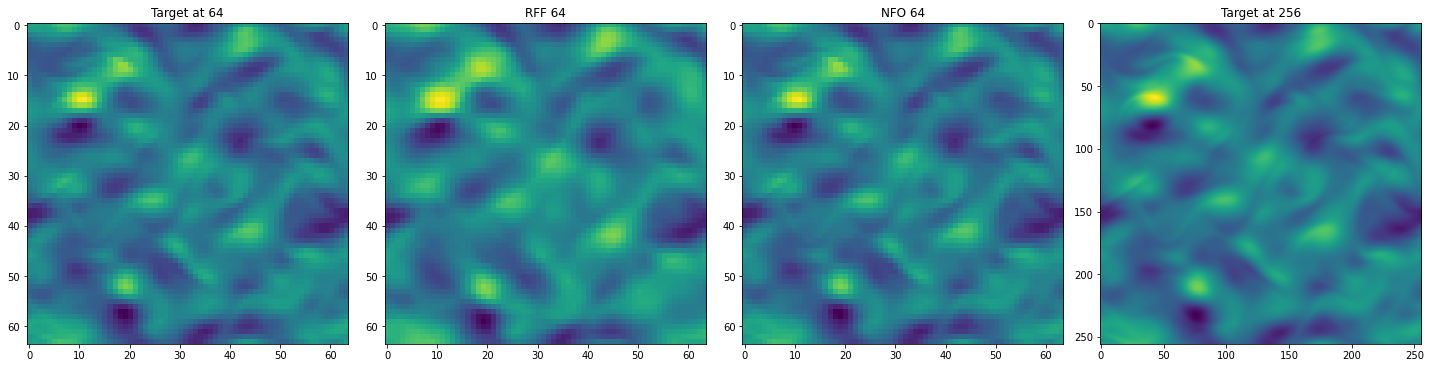

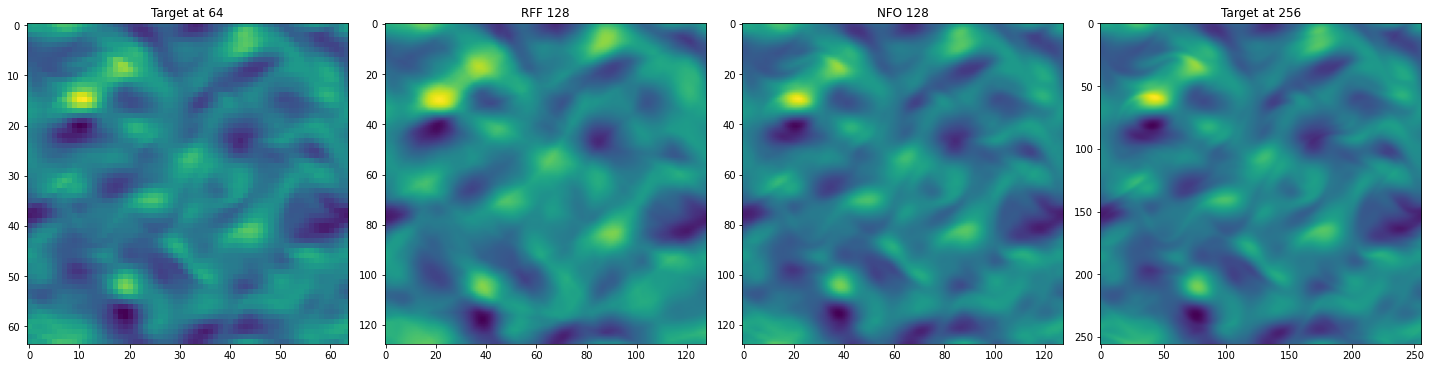

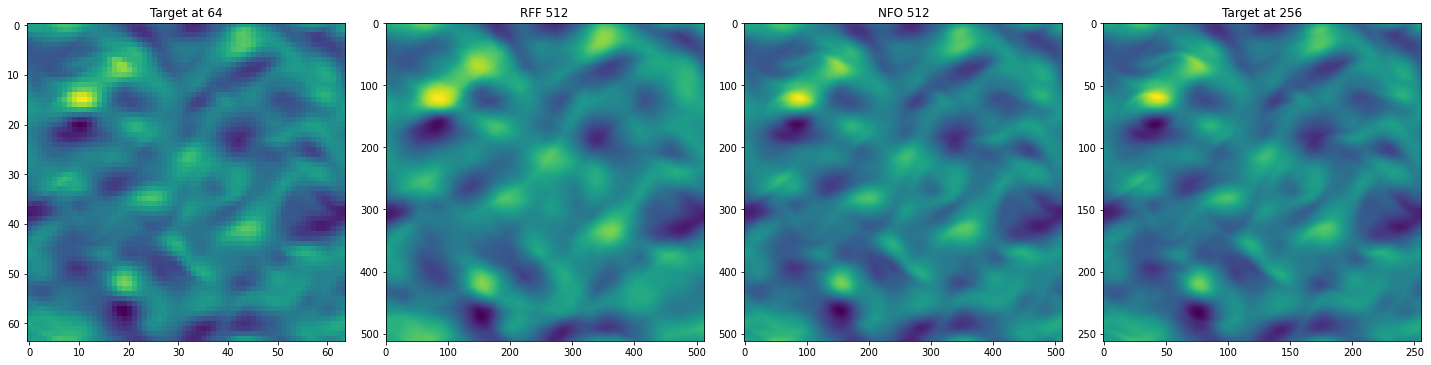

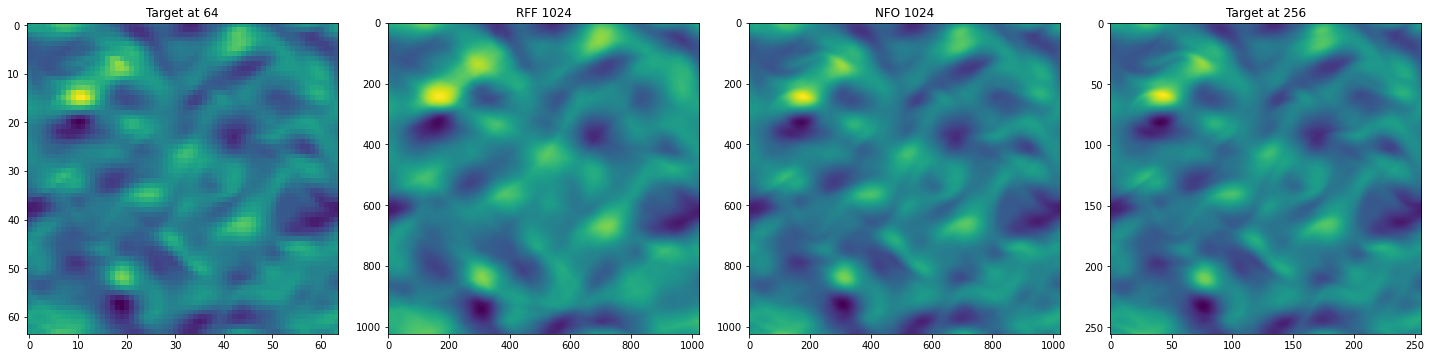

In [38]:
def my_pred(ngrid, model):
    model.eval().to(device)
    coords = np.linspace(0, 1, ngrid, endpoint=False)
    coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
    tmp = coords[:,:,0].copy()
    coords[:,:,0] = coords[:,:,1]
    coords[:,:,1] = tmp
    pred = model(torch.from_numpy(coords).float().to(device)[None,...])
    ypred = pred.cpu().detach().numpy().squeeze()
    return ypred

for res in [64, 128, 512, 1024]:

    FNOpred = my_pred(res, model_dict['FNO'])
    RFFpred = my_pred(res, model_dict['RFF'])
    
    figsize = (20,20)
    fig, axs = plt.subplots(1,4, figsize=figsize)
    axs[0].imshow(ytrain[:,:,1].squeeze())
    axs[0].set_title('Target at %d' % 64)
    axs[1].imshow(RFFpred[:,:,1])
    axs[1].set_title('RFF %d' % res)
    axs[2].imshow(FNOpred[:,:,1])
    axs[2].set_title('NFO %d' % res)
    axs[3].imshow(ytest[:,:,1].squeeze())
    axs[3].set_title('Target at %d' % 256)
    plt.tight_layout()
    plt.show()

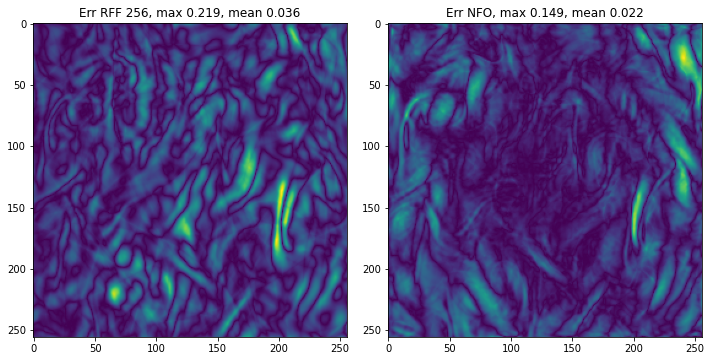

In [14]:
FNOpred = my_pred(256, model_dict['FNO'])
RFFpred = my_pred(256, model_dict['RFF'])

figsize = (10,10)
fig, axs = plt.subplots(1,2, figsize=figsize)
errRFF = np.abs(ytest[:,:,0].squeeze() - RFFpred[:,:,0])
errNFO = np.abs(ytest[:,:,0].squeeze() - FNOpred[:,:,0])
axs[0].imshow(errRFF)
axs[0].set_title('Err RFF 256, max %1.3f, mean %1.3f' % (np.max(errRFF), np.mean(errRFF)))
axs[1].imshow(errNFO)
axs[1].set_title('Err NFO, max %1.3f, mean %1.3f' % (np.max(errNFO), np.mean(errNFO)))
plt.tight_layout()
plt.show()

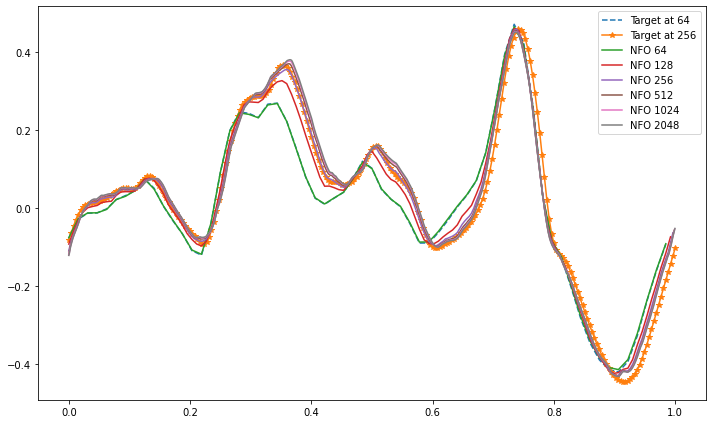

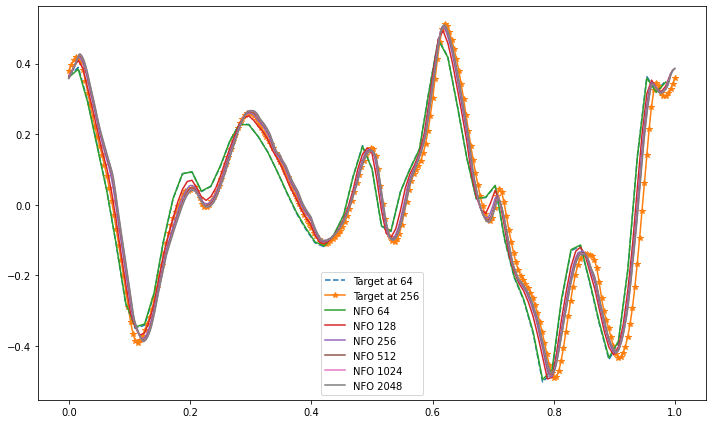

In [20]:
figsize = (10,6)
fig, axs = plt.subplots(1,1, figsize=figsize)
plt.plot(np.linspace(0,1-1/64,64), ytrain[:,32,0].squeeze(), '--', label='Target at %d' % 64)
plt.plot(np.linspace(0,1,256), ytest[:,128,0].squeeze(), '-*', label='Target at %d' % 256)

for res in [64, 128, 256, 512, 1024, 2048]:
    FNOpred = my_pred(res, model_dict['FNO'])
    plt.plot(np.linspace(0,1-1/res,res), FNOpred[:,int(res//2),0].squeeze(), label='NFO %d' % res)

plt.legend()
plt.tight_layout()
plt.show()

figsize = (10,6)
fig, axs = plt.subplots(1,1, figsize=figsize)
plt.plot(np.linspace(0,1-1/64,64), ytrain[32,:,0].squeeze(), '--', label='Target at %d' % 64)
plt.plot(np.linspace(0,1,256), ytest[128,:,0].squeeze(), '-*', label='Target at %d' % 256)

for res in [64, 128, 256, 512, 1024, 2048]:
    FNOpred = my_pred(res, model_dict['FNO'])
    plt.plot(np.linspace(0,1-1/res,res), FNOpred[int(res//2),:,0].squeeze(), label='NFO %d' % res)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Npred256 = my_pred(256, model_dict['None'])
Npred256ph = my_pred(256, model_dict['NonePh'])
Fpred256 = my_pred(256, model_dict['Fourier10'])
Fpred256ph = my_pred(256, model_dict['Fourier10Ph'])
Ipred256 = my_intr(256,Xtrain, ytrain)
Npred512 = my_pred(512, model_dict['None'])
Fpred512 = my_pred(512, model_dict['Fourier10'])
Npred512Ph = my_pred(512, model_dict['NonePh'])
Fpred512Ph = my_pred(512, model_dict['Fourier10Ph'])
Ipred512 = my_intr(512,Xtrain, ytrain)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
# plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_TGT.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_INT.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_NONE.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_RFF.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()